#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import math
import random
import os
import soundfile as sf

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# change to this notebook's directory
!ls '/content/drive/My Drive/UVic/Synthesizer Programming/audio'
path = '/content/drive/My Drive/UVic/Synthesizer Programming/audio/'

Mounted at /content/drive
demucs	mdx  original  spleeter  synth	test


In [3]:
%%capture
!pip install nussl
import nussl


    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


## Phase Mix + Match

### Load audio data

I use the bass stem of a 7-second segment of a song from MUSDB18 that was source separated by Demucs, Hybrid Demucs (MDX), and Spleeter.

In [4]:
stems = {}
sr = 44100

for dir in os.listdir(path):
  if 'test' in dir:
    continue
  else:
    stems[dir], _ = librosa.load(path+dir+'/bass.wav', sr=sr)

stems['original_mix'], _ = librosa.load(path+'original/mix.wav', sr=sr)

In [5]:
ipd.display(ipd.Audio(stems['original_mix'], rate=sr))

### Separate phase data from stems

In [6]:
mags = {}
phases = {}

for name, data in stems.items():
  # convert waveforms to spectrogram data
  D = librosa.stft(data)
  mag, phase = librosa.magphase(D)

  # save magnitude and phase data separately
  mags[name] = mag
  phases[name] = phase

In [7]:
del mags['synth']
del mags['original']
del mags['original_mix']
del phases['demucs']
del phases['mdx']
del phases['spleeter']

### Apply different phases to each stem

Each stem is combined with the following phase data:
1. the original mix
2. the original bass stem
3. the MIDI stem
4. a Griffin-Lim reconstruction
5. no phase data

This results in 3 stems * 5 phase types = 15 stems to evaluate

In [12]:
outputs = {}

for name, data in mags.items():
  # Original Mix
  if name != 'original_mix':
    key = name + '_original_mix'
    outputs[key] = data * np.exp(1j * phases['original_mix'])

  # Original Stem
  if name != 'original':
    key = name + '_original'
    outputs[key] = data * np.exp(1j * phases['original'])
  
  # MIDI
  if name != 'synth':
    key = name + '_synth'
    outputs[key] = data * np.exp(1j * phases['synth'])

  # Griffin-Lim
  key = name + '_griffin_lim'
  gl = librosa.griffinlim(data)
  outputs[key] = gl

  # No Phase
  key = name + '_no_phase'
  outputs[key] = data

### Convert STFTs to waveforms and save audio

In [14]:
output_wavs = {}
for name, data in outputs.items():
  if 'griffin_lim' in name:
    inv = data
  else:
    inv = librosa.istft(data)
  
  output_wavs[name] = inv

  filepath = path + 'test/' + name + '.wav'
  sf.write(filepath, inv, samplerate=sr)

## Objective Quality Evaluation

I use the implementation of scale-invariant signal-to-distortion ratio (SI-SDR) from the `nussl` library (https://nussl.github.io/docs/evaluation.html#scale-invariant-bsseval). Scores are measured in decibels (dB) and higher scores are better.

In [15]:
from nussl import evaluation

In [41]:
gt_wav = stems['original'][:output_wavs['mdx_synth'].size]
gt = nussl.AudioSignal(audio_data_array=gt_wav, sample_rate=sr)

A common issue with SI-SDR is the alignment of the reference and test signals. If the peaks do not occur at the same indices, the SDR score can be greatly affected. Here, I roll through a test signal to find in which alignment it achieves the best score, implying the correct alignment.

In [ ]:
test = output_wavs['mdx_synth']
best_score = -111111111111
best_shift = 0
for i in range(test.size):
  test = np.roll(test, 1)
  x = nussl.AudioSignal(audio_data_array=test, sample_rate=sr)

  bsseval = evaluation.BSSEvalScale(gt, x)

  scores = bsseval.evaluate()
  score = scores['source_0']['SI-SDR'][0]
  if score > best_score:
    best_score = score
    best_shift = i

print(best_shift, best_score)

In [42]:
for name, data in output_wavs.items():
  # roll all data by the same shift amount
  data = np.roll(data, 130940)
  test = nussl.AudioSignal(audio_data_array=data, sample_rate=sr)

  # SI-SDR evaluation
  bsseval = evaluation.BSSEvalScale(gt, test)
  score = bsseval.evaluate()

  scores[name] = score['source_0']['SI-SDR'][0]

In [39]:
scores = {}

In [40]:
gt_wav = stems['original']
gt = nussl.AudioSignal(audio_data_array=gt_wav, sample_rate=sr)

seps = ['demucs', 'mdx', 'spleeter']
for s in seps:
  test_wav = stems[s]
  test = nussl.AudioSignal(audio_data_array=test_wav, sample_rate=sr)
  bsseval = evaluation.BSSEvalScale(gt, test)
  score = bsseval.evaluate()

  scores[s] = score['source_0']['SI-SDR'][0]

In [62]:
demucs = {}
mdx = {}
spleeter = {}

for name, score in scores.items():
  if 'demucs' in name:
    if name == 'demucs':
      n = 'demucs'
    else:
      n = name.split('demucs_')[1]
      n = n.replace('_', ' ')
    if n == 'original':
      n = 'original stem'
    demucs[n] = score

  elif 'mdx' in name:
    if name == 'mdx':
      n = 'mdx'
    else:
        n = name.split('mdx_')[1]
        n = n.replace('_', ' ')
    if n == 'original':
      n = 'original stem'
    mdx[n] = score

  elif 'spleeter' in name:
    if name == 'spleeter':
      n = 'spleeter'
    else:
      n = name.split('spleeter_')[1]
      n = n.replace('_', ' ')
    if n == 'original':
      n = 'original stem'
    spleeter[n] = score

### Results

Below, I present the SDR scores for each of the experimental stems as well as the score for the actual outputs of the three source separation models. SDR is measured in decibels and higher scores are better.

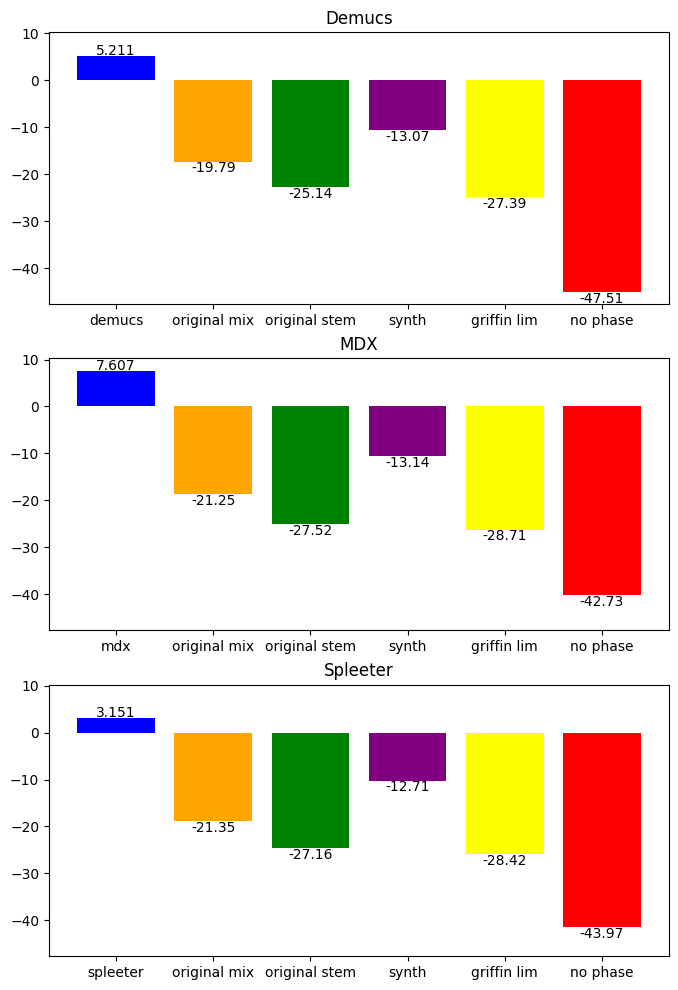

In [63]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,12), sharey=True)
c = ['blue', 'orange', 'green', 'purple', 'yellow', 'red']

cc = ax[0].bar(demucs.keys(), demucs.values(), color=c)
ax[0].set_title('Demucs')
for p in cc:
  height = p.get_height()
  if height < 0:
    height -= 2.5
  ax[0].annotate('{0:.4g}'.format(height),
                 xy=(p.get_x() + p.get_width() / 2, height),
                 xytext=(0,-1.5),
                 textcoords='offset points',
                 ha='center', va='bottom')
# ax[0].label_outer()

cc = ax[1].bar(mdx.keys(), mdx.values(), color=c)
ax[1].set_title('MDX')
for p in cc:
  height = p.get_height()
  if height < 0:
    height -= 2.5
  ax[1].annotate('{0:.4g}'.format(height),
                 xy=(p.get_x() + p.get_width() / 2, height),
                 xytext=(0,-1.5),
                 textcoords='offset points',
                 ha='center', va='bottom')
# ax[1].label_outer()

cc = ax[2].bar(spleeter.keys(), spleeter.values(), color=c)
ax[2].set_title('Spleeter')
for p in cc:
  height = p.get_height()
  if height < 0:
    height -= 2.5
  ax[2].annotate('{0:.4g}'.format(height),
                 xy=(p.get_x() + p.get_width() / 2, height),
                 xytext=(0,-1.5),
                 textcoords='offset points',
                 ha='center', va='bottom')
# ax[2].label_outer()

plt.show()

In the above plots, I see a consistent trend between the source separation models where the stem with phase from the synthesized, MIDI recording (`synth`) achieved the best score, and the stem without any phase data got the worst score. Although `synth` was the best of the experimental stems, a negative SDR is still not good enough to contend with the scores achieved by existing source separation models.

### Subjective Evaluation

Below, I present the Mean Opinion Score (MOS) ratings I collected for each of the experimental stems. The number of listeners was not enough to be more than anecdotal, but it's still worth looking at with that in mind.

MOS is an average of integer scores on the range 1 to 5, where 1 indicates Bad quality and 5 indicates Excellent. Higher scores are better.

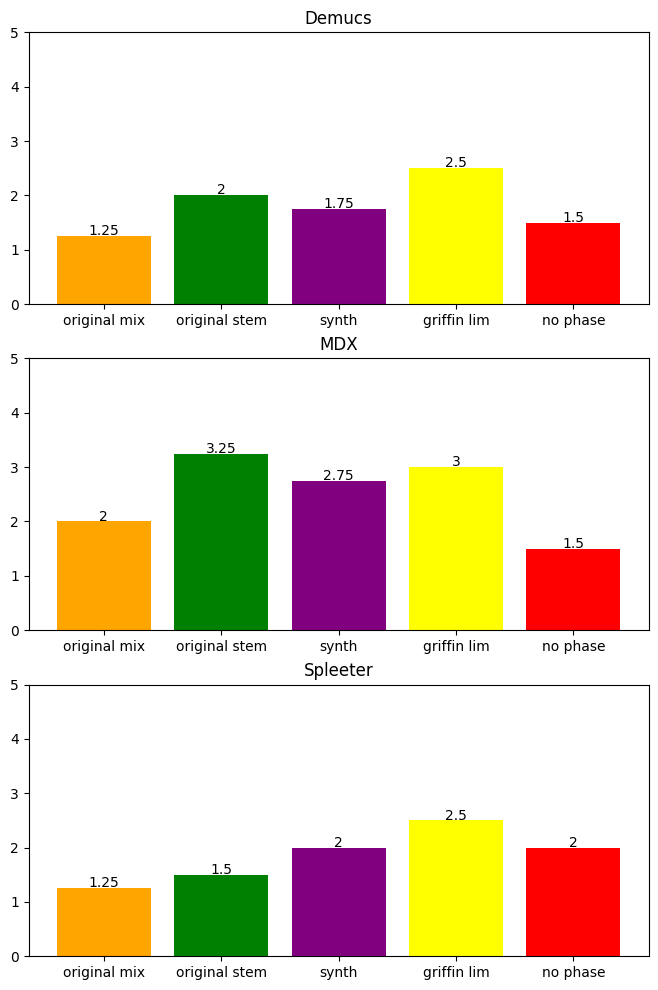

In [66]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,12), sharey=True)
c = ['orange', 'green', 'purple', 'yellow', 'red']
labels = ['original mix', 'original stem', 'synth', 'griffin lim', 'no phase']

plt.ylim([0,5])

demucs_mos = [1.25, 2, 1.75, 2.5, 1.5]
cc = ax[0].bar(labels, demucs_mos, color=c)
ax[0].set_title('Demucs')
for p in cc:
  height = p.get_height()
  if height < 0:
    height -= 2.5
  ax[0].annotate('{0:.4g}'.format(height),
                 xy=(p.get_x() + p.get_width() / 2, height),
                 xytext=(0,-1.5),
                 textcoords='offset points',
                 ha='center', va='bottom')
# ax[0].label_outer()

mdx_mos = [2, 3.25, 2.75, 3, 1.5]
cc = ax[1].bar(labels, mdx_mos, color=c)
ax[1].set_title('MDX')
for p in cc:
  height = p.get_height()
  if height < 0:
    height -= 2.5
  ax[1].annotate('{0:.4g}'.format(height),
                 xy=(p.get_x() + p.get_width() / 2, height),
                 xytext=(0,-1.5),
                 textcoords='offset points',
                 ha='center', va='bottom')
# ax[1].label_outer()

spleeter_mos = [1.25, 1.5, 2, 2.5, 2]
cc = ax[2].bar(labels, spleeter_mos, color=c)
ax[2].set_title('Spleeter')
for p in cc:
  height = p.get_height()
  if height < 0:
    height -= 2.5
  ax[2].annotate('{0:.4g}'.format(height),
                 xy=(p.get_x() + p.get_width() / 2, height),
                 xytext=(0,-1.5),
                 textcoords='offset points',
                 ha='center', va='bottom')
# ax[2].label_outer()

plt.show()

Unlike the SDR results, the MOS ratings between source separation outputs were not consistent between each other nor with the SDR results. This further confirms my observations that SDR does not correlate with the opinions of human listeners.